We install all necessary libraries first:

In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

We load datasource into pandas dataframe:

In [162]:
df = pd.read_csv('./data/apple_stock.csv')

In [163]:
df.head()
df = df.rename(columns=lambda x: x.strip())

We use only 2 colums: Date and Close

In [164]:
df = df.iloc[:,:2]
df.rename(columns={'Close/Last' : 'Close'}, inplace=True)
# df.reset_index(drop=True)
df.head()

,Date,Close
0,02/28/2020,$273.36
1,02/27/2020,$273.52
2,02/26/2020,$292.65
3,02/25/2020,$288.08
4,02/24/2020,$298.18


Remove dollar sign '$' from Close values and convert them to numeric

In [165]:
df = df.replace({'\$':''}, regex = True)


In [166]:
df = df.astype({"Close": float})
df["Date"] = pd.to_datetime(df.Date, format="%m/%d/%Y")
df.dtypes

Date     datetime64[ns]
Close           float64
dtype: object

Make Date become index of the dataframe for visualization purpose:

In [167]:
df.index = df['Date']


Visualize chart:

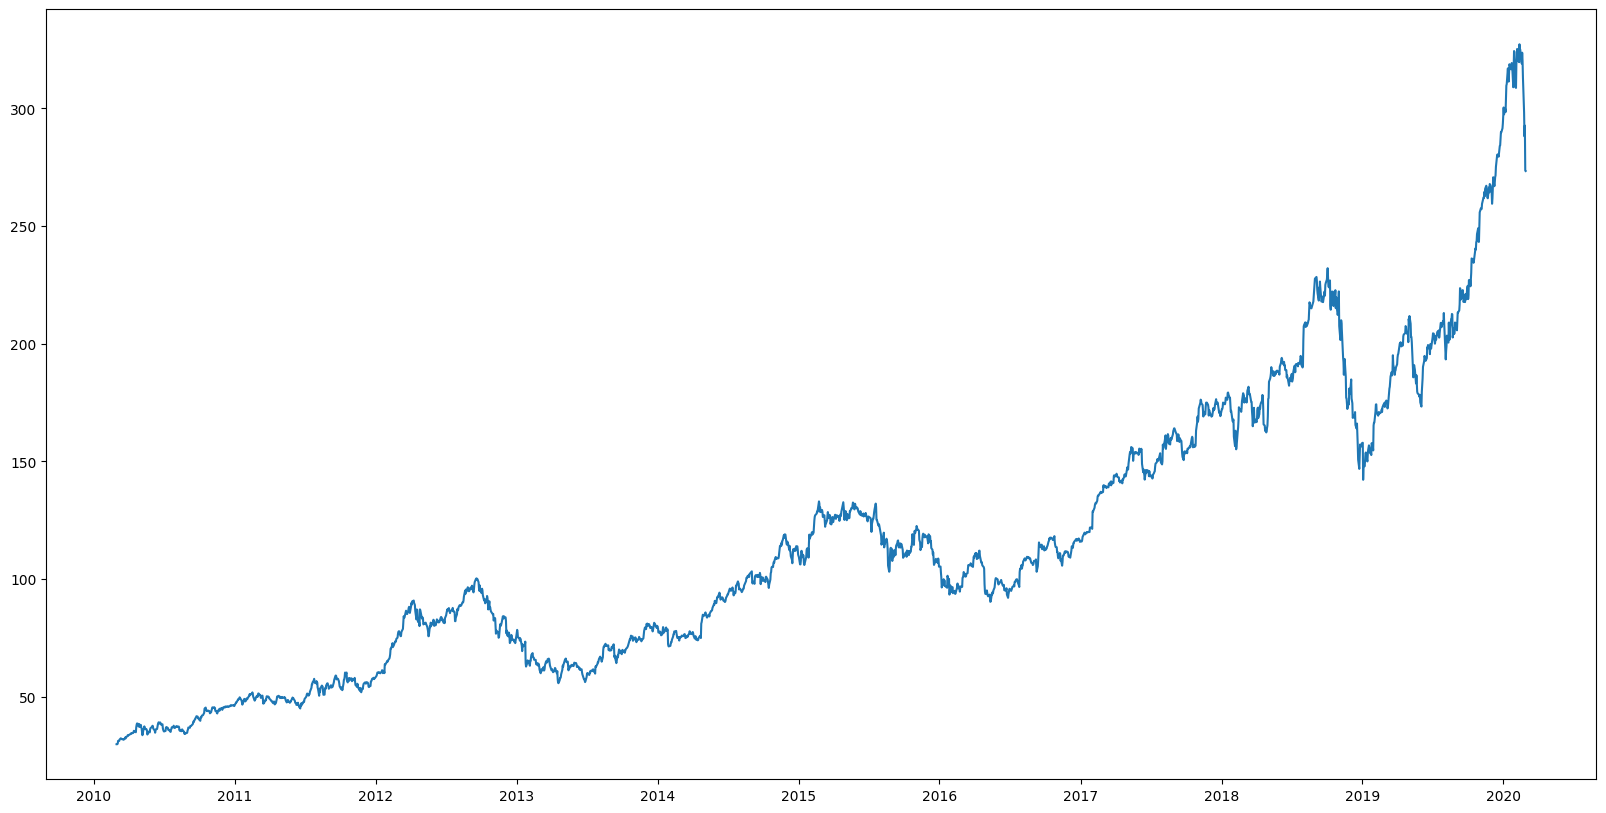

In [168]:
plt.plot(df["Close"],label='Close Price history')

In [169]:
df = df.sort_index(ascending=True,axis=0)
data = pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    data['Date'][i] = df['Date'][i]
    data['Close'][i] = df['Close'][i]

In [170]:
data.head()

,Date,Close
0,2010-03-01 00:00:00,29.8557
1,2010-03-02 00:00:00,29.8357
2,2010-03-03 00:00:00,29.9043
3,2010-03-04 00:00:00,30.1014
4,2010-03-05 00:00:00,31.2786


In [171]:
data.index=data.Date
data.drop("Date",axis=1,inplace=True)
final_data = data.values
train_data=final_data[0:600,:]
valid_data=final_data[600:,:]
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_data)
x_train_data,y_train_data=[],[]
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

In [172]:
len(data)

2518

In [173]:
len(valid_data)

1918

In [174]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(np.shape(x_train_data)[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
model_data=data[len(data)-len(valid_data)-60:].values
model_data=model_data.reshape(-1,1)
model_data=scaler.transform(model_data)

In [175]:
x_train_data = np.asarray(x_train_data)
y_train_data = np.asarray(y_train_data)


In [176]:
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)
X_test=[]
for i in range(60,model_data.shape[0]):
    X_test.append(model_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

540/540 - 7s - loss: 1.9703e-04 - 7s/epoch - 13ms/step


In [177]:
predicted_stock_price=lstm_model.predict(X_test)
predicted_stock_price=scaler.inverse_transform(predicted_stock_price)

60/60 [==============================] - 1s 7ms/step


C:\Users\tranh\AppData\Local\Temp\ipykernel_15972\1858432017.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_stock_price


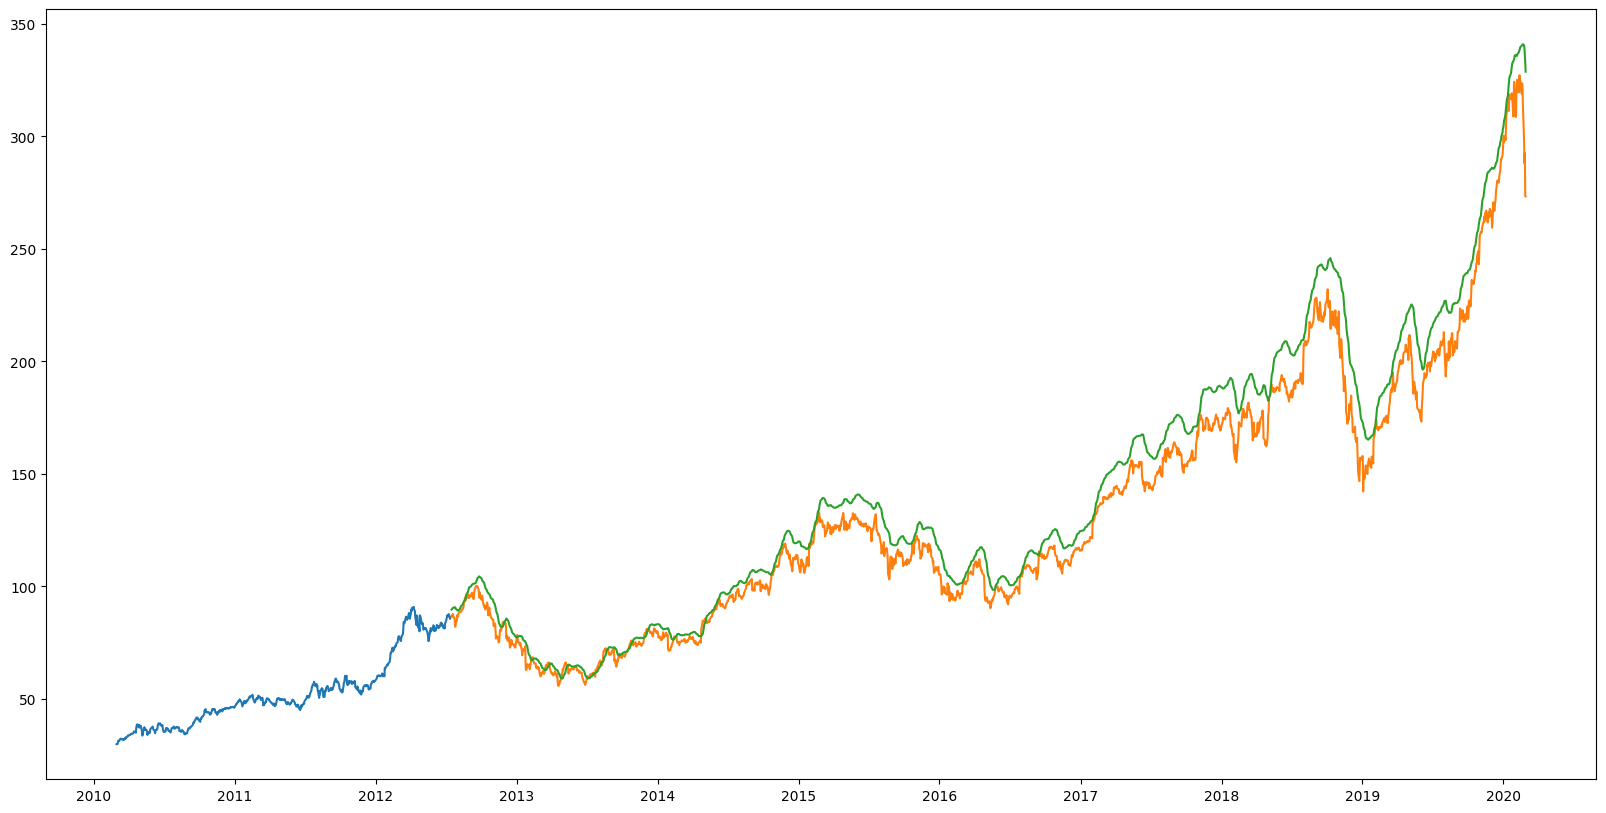

In [179]:
train_data=data[:600]
valid_data=data[600:]
valid_data['Predictions']=predicted_stock_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])